# Data Preparation

In [2]:
# Install the OpenSlide C library and Python bindings
# After installing these libraries, use `Runtime -> restart and run all` on the menu
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
from google.colab import drive
import pandas as pd


### Data Exploration on tumor_091 at level 5

In [3]:
# Download an example slide and tumor mask

# Note: the remainder of the training data are in the Google Drive folder linked above.
# You will need to host them on your own, either in Google Drive, or by using
# the cloud provider of your choice.

slide_path = 'tumor_091.tif' # only this file is available
tumor_mask_path = 'tumor_091_mask.tif' # only this file is available

slide_url = 'https://storage.googleapis.com/applied-dl/%s' % slide_path
mask_url = 'https://storage.googleapis.com/applied-dl/%s' % tumor_mask_path

# Download the whole slide image
if not os.path.exists(slide_path):
  !curl -O $slide_url

# Download the tumor mask
if not os.path.exists(tumor_mask_path):
  !curl -O $mask_url

In [4]:
slide = open_slide(slide_path)
print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                        slide.level_dimensions[0][0], 
                                                        slide.level_dimensions[0][1]))

tumor_mask = open_slide(tumor_mask_path)
print ("Read tumor mask from %s" % (tumor_mask_path))

print("Slide includes %d levels", len(slide.level_dimensions))
for i in range(len(slide.level_dimensions)):
    print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                             slide.level_dimensions[i], 
                                                             slide.level_downsamples[i]))
    assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
    assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

# Verify downsampling works as expected
width, height = slide.level_dimensions[7]
assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

Read WSI from tumor_091.tif with width: 61440, height: 53760
Read tumor mask from tumor_091_mask.tif
Slide includes %d levels 8
Level 0, dimensions: (61440, 53760) downsample factor 1
Level 1, dimensions: (30720, 26880) downsample factor 2
Level 2, dimensions: (15360, 13440) downsample factor 4
Level 3, dimensions: (7680, 6720) downsample factor 8
Level 4, dimensions: (3840, 3360) downsample factor 16
Level 5, dimensions: (1920, 1680) downsample factor 32
Level 6, dimensions: (960, 840) downsample factor 64
Level 7, dimensions: (480, 420) downsample factor 128


In [5]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

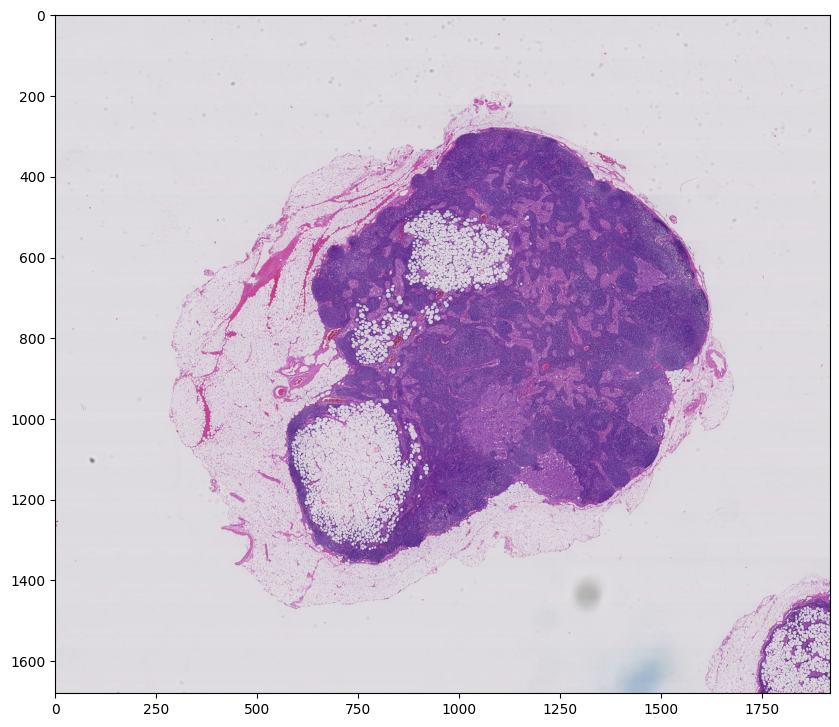

In [6]:
# Example: read the entire slide at level 5

# Higher zoom levels may not fit into memory.
# You can use the below function to extract regions from higher zoom levels 
# without having to read the entire image into ram.

# Use the sliding window approach discussed in class to collect training
# data for your classifier. E.g., slide a window across the slide (for
# starters, use a zoomed out view, so you're not working with giant images).
# Save each window to disk as an image. To find the label for that image, 
# check to the tissue mask to see if the same region contains cancerous cells.

# Important: this is tricky to get right. Carefully debug your pipeline before
# training your model. Start with just a single image, and a relatively 
# low zoom level.

slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=slide.level_dimensions[5][0], 
                         height=slide.level_dimensions[5][1])

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)

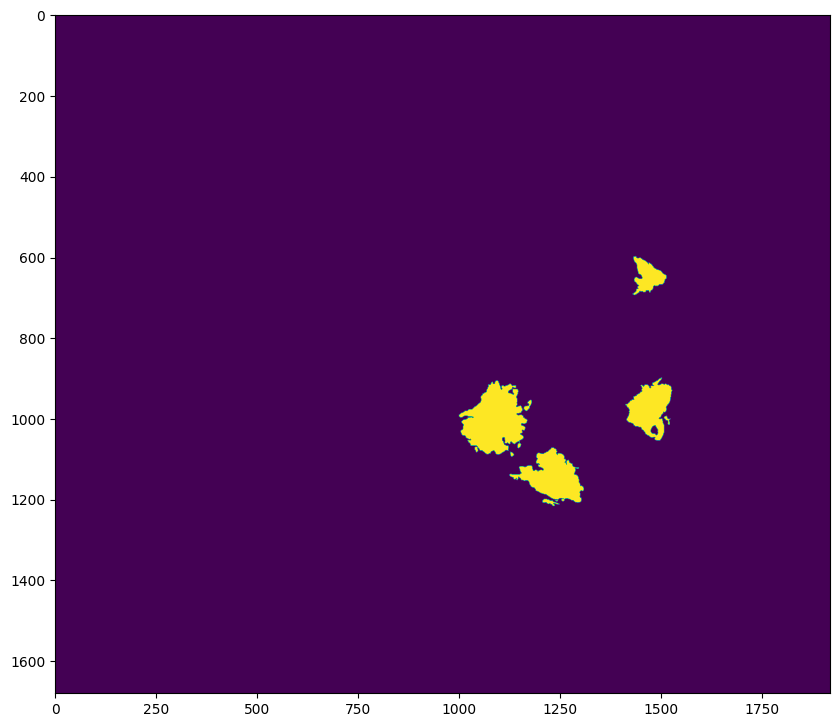

In [7]:
# Example: read the entire mask at the same zoom level
mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=5, 
                        width=slide.level_dimensions[5][0], 
                        height=slide.level_dimensions[5][1])

# Note: the program provided by the dataset authors generates a mask with R,G,B channels.
# The mask info we need is in the first channel only.
# If you skip this step, the mask will be displayed as all black.
mask_image = mask_image[:,:,0]

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(mask_image)

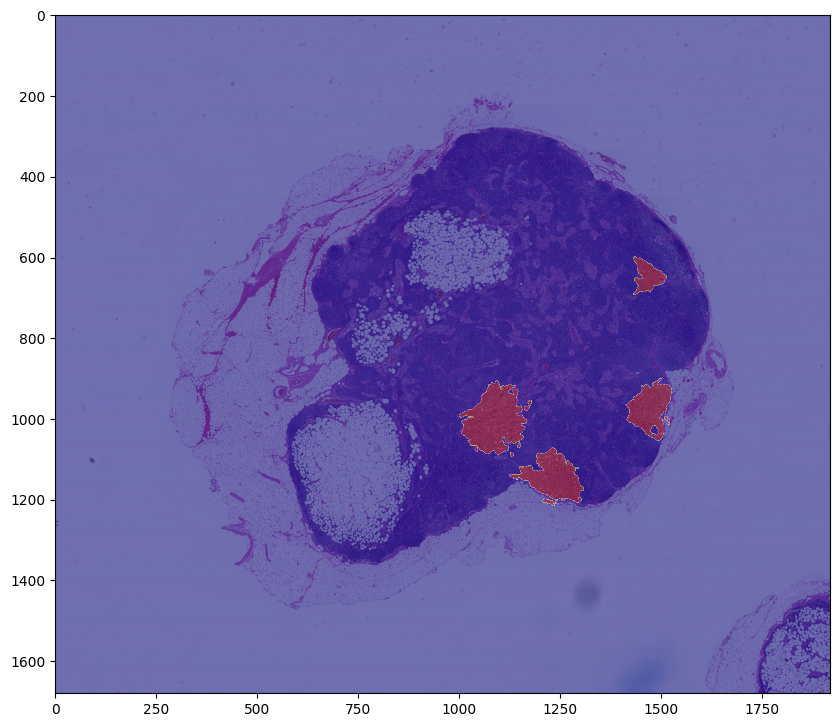

In [8]:
# Overlay them. The idea is that the mask shows the region of the slide that
# contain cancerous cells.
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='jet', alpha=0.5) # Red regions contains cancer.

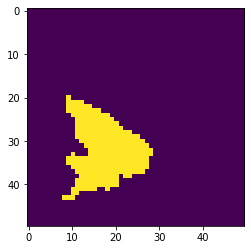

In [9]:
# Example: extract a region from the L7 downsampled image
# Notice we're multiplying the x,y coordinates by the downsample factor.
# This math can be tricky to get right, debug carefully.
# Here, we're "aiming" for the top right blob in the image above.
region = read_slide(tumor_mask, x=350 * 128, y=130 * 128, level=7, width=50, height=50)[:,:,0]
plt.imshow(region)

905504 tissue_pixels pixels (28.1 percent of the image)


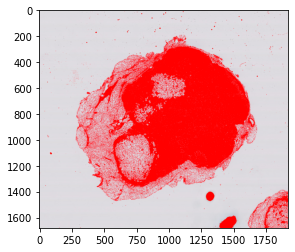

In [10]:
# As mentioned in class, we can improve efficiency by ignoring non-tissue areas 
# of the slide. We'll find these by looking for all gray regions.
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return list(zip(indices[0], indices[1]))

tissue_pixels = find_tissue_pixels(slide_image)
percent_tissue = len(tissue_pixels) / float(slide_image.shape[0] * slide_image.shape[1]) * 100
print ("%d tissue_pixels pixels (%.1f percent of the image)" % (len(tissue_pixels), percent_tissue)) 

def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

tissue_regions = apply_mask(slide_image, tissue_pixels)
plt.imshow(tissue_regions)

## Save Slices to Disk

In [2]:
drive.mount('/content/gdrive/')
drive_root_dir = '/content/gdrive/My Drive/'
slides_directory_path = drive_root_dir+'slides/'

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [3]:
from generate_slices import Slide2Slice

In [4]:
all_data_slides=[ 'tumor_001', 'tumor_002', 'tumor_005', 
                   'tumor_012', 'tumor_016', 'tumor_019', 
                   'tumor_023', 'tumor_031', 'tumor_035', 
                   'tumor_057', 'tumor_059', 'tumor_064',
                   'tumor_075', 'tumor_078', 'tumor_081', 
                   'tumor_084', 'tumor_091', 'tumor_094', 
                   'tumor_096', 'tumor_101', 'tumor_110',]

train_data_slides = all_data_slides[:18] # 18 Training Slides
test_data_slides = all_data_slides[18:] # 3 Testing Slides
train_sliced_slides_dir = drive_root_dir + 'slices_train/'
test_sliced_slides_dir = drive_root_dir + 'slices_test/'

### Level 3

In [14]:
level = 3
slice_size = 229

In [15]:
# ! rm -r '/content/gdrive/My Drive/slices_train/level3/'

In [16]:
stats_df = Slide2Slice(train_data_slides,
                       slides_directory_path, 
                       sliced_slides_dir=train_sliced_slides_dir, 
                       level=level,
                       slice_size=slice_size).run()

slicing tumor_001 on level 3 and size 229
{'slide_name': 'tumor_001', 'level': 3, 'negative': 6349, 'positive': 11, 'negative_with_tissue': 1015, 'positive_with_tissue': 11}
slicing tumor_002 on level 3 and size 229
{'slide_name': 'tumor_002', 'level': 3, 'negative': 6304, 'positive': 3, 'negative_with_tissue': 542, 'positive_with_tissue': 3}
slicing tumor_005 on level 3 and size 229
{'slide_name': 'tumor_005', 'level': 3, 'negative': 6301, 'positive': 6, 'negative_with_tissue': 527, 'positive_with_tissue': 6}
slicing tumor_012 on level 3 and size 229
{'slide_name': 'tumor_012', 'level': 3, 'negative': 6197, 'positive': 4, 'negative_with_tissue': 624, 'positive_with_tissue': 2}
slicing tumor_016 on level 3 and size 229
{'slide_name': 'tumor_016', 'level': 3, 'negative': 6278, 'positive': 82, 'negative_with_tissue': 472, 'positive_with_tissue': 82}
slicing tumor_019 on level 3 and size 229
{'slide_name': 'tumor_019', 'level': 3, 'negative': 6302, 'positive': 5, 'negative_with_tissue': 4

In [26]:
stats_df.to_csv('level3.csv')
stats_df

,slide_name,level,negative,positive,negative_with_tissue,positive_with_tissue
0,tumor_001,4,1556,4,287,4
1,tumor_002,4,1532,2,117,2
2,tumor_005,4,1530,4,135,4
3,tumor_012,4,1504,4,139,2
4,tumor_016,4,1530,30,100,29
5,tumor_019,4,1532,2,93,2
6,tumor_023,4,1553,7,152,7
7,tumor_031,4,1524,36,52,33
8,tumor_035,4,1558,2,157,2
9,tumor_057,4,1556,4,137,4


In [18]:
test_stats_df = pd.DataFrame()
level_df = Slide2Slice(test_data_slides,
                        slides_directory_path, 
                        sliced_slides_dir=test_sliced_slides_dir, 
                        level=level,
                        slice_size=slice_size,
                        save=False).run()
test_stats_df = test_stats_df.append(level_df, ignore_index=True)


slicing tumor_096 on level 3 and size 229
{'slide_name': 'tumor_096', 'level': 3, 'negative': 2725, 'positive': 44, 'negative_with_tissue': 920, 'positive_with_tissue': 44}
slicing tumor_101 on level 3 and size 229
{'slide_name': 'tumor_101', 'level': 3, 'negative': 2845, 'positive': 119, 'negative_with_tissue': 830, 'positive_with_tissue': 119}
slicing tumor_110 on level 3 and size 229
{'slide_name': 'tumor_110', 'level': 3, 'negative': 1557, 'positive': 432, 'negative_with_tissue': 454, 'positive_with_tissue': 426}


In [27]:
test_stats_df.to_csv('level3_test.csv')
test_stats_df

,slide_name,level,negative,positive,negative_with_tissue,positive_with_tissue
0,tumor_096,4,643,22,255,20
1,tumor_101,4,672,50,221,46
2,tumor_110,4,348,127,113,122


### Level 4

In [20]:
level = 4
slice_size = 229

In [21]:
# ! rm -r '/content/gdrive/My Drive/slices_train/level4/'

In [22]:
stats_df = Slide2Slice(train_data_slides,
                       slides_directory_path, 
                       sliced_slides_dir=train_sliced_slides_dir, 
                       level=level,
                       slice_size=slice_size).run()

slicing tumor_001 on level 4 and size 229
{'slide_name': 'tumor_001', 'level': 4, 'negative': 1556, 'positive': 4, 'negative_with_tissue': 287, 'positive_with_tissue': 4}
slicing tumor_002 on level 4 and size 229
{'slide_name': 'tumor_002', 'level': 4, 'negative': 1532, 'positive': 2, 'negative_with_tissue': 117, 'positive_with_tissue': 2}
slicing tumor_005 on level 4 and size 229
{'slide_name': 'tumor_005', 'level': 4, 'negative': 1530, 'positive': 4, 'negative_with_tissue': 135, 'positive_with_tissue': 4}
slicing tumor_012 on level 4 and size 229
{'slide_name': 'tumor_012', 'level': 4, 'negative': 1504, 'positive': 4, 'negative_with_tissue': 139, 'positive_with_tissue': 2}
slicing tumor_016 on level 4 and size 229
{'slide_name': 'tumor_016', 'level': 4, 'negative': 1530, 'positive': 30, 'negative_with_tissue': 100, 'positive_with_tissue': 29}
slicing tumor_019 on level 4 and size 229
{'slide_name': 'tumor_019', 'level': 4, 'negative': 1532, 'positive': 2, 'negative_with_tissue': 93, 

In [28]:
stats_df.to_csv('level4.csv')
stats_df

,slide_name,level,negative,positive,negative_with_tissue,positive_with_tissue
0,tumor_001,4,1556,4,287,4
1,tumor_002,4,1532,2,117,2
2,tumor_005,4,1530,4,135,4
3,tumor_012,4,1504,4,139,2
4,tumor_016,4,1530,30,100,29
5,tumor_019,4,1532,2,93,2
6,tumor_023,4,1553,7,152,7
7,tumor_031,4,1524,36,52,33
8,tumor_035,4,1558,2,157,2
9,tumor_057,4,1556,4,137,4


In [24]:
test_stats_df = pd.DataFrame()
level_df = Slide2Slice(test_data_slides,
                        slides_directory_path, 
                        sliced_slides_dir=test_sliced_slides_dir, 
                        level=level,
                        slice_size=slice_size,
                        save=False).run()
test_stats_df = test_stats_df.append(level_df, ignore_index=True)


slicing tumor_096 on level 4 and size 229
{'slide_name': 'tumor_096', 'level': 4, 'negative': 643, 'positive': 22, 'negative_with_tissue': 255, 'positive_with_tissue': 20}
slicing tumor_101 on level 4 and size 229
{'slide_name': 'tumor_101', 'level': 4, 'negative': 672, 'positive': 50, 'negative_with_tissue': 221, 'positive_with_tissue': 46}
slicing tumor_110 on level 4 and size 229
{'slide_name': 'tumor_110', 'level': 4, 'negative': 348, 'positive': 127, 'negative_with_tissue': 113, 'positive_with_tissue': 122}


In [29]:
test_stats_df.to_csv('level4_test.csv')
test_stats_df

,slide_name,level,negative,positive,negative_with_tissue,positive_with_tissue
0,tumor_096,4,643,22,255,20
1,tumor_101,4,672,50,221,46
2,tumor_110,4,348,127,113,122


# Model Training

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Load Data

In [6]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_sliced_slides_dir = drive_root_dir + 'slices_train/'

print('\nLoading level 4 train and val data')
train_level4_path = train_sliced_slides_dir + 'level4/'
lvl4_train_data = tf.keras.preprocessing.image_dataset_from_directory( 
                train_level4_path, labels='inferred', label_mode='binary',
                class_names=['0negative','1positive'], image_size=(229,229), 
                shuffle=True, seed=1, validation_split=0.2, subset='training')


lvl4_val_data = tf.keras.preprocessing.image_dataset_from_directory( 
                train_level4_path, labels='inferred', label_mode='binary',
                class_names=['0negative','1positive'], image_size=(229,229), 
                shuffle=True, seed=1, validation_split=0.2, subset='validation')

print('\nLoading level 3 train and val data')
train_level3_path = train_sliced_slides_dir + 'level3/'
lvl3_train_data = tf.keras.preprocessing.image_dataset_from_directory( 
                train_level3_path, labels='inferred', label_mode='binary',
                class_names=['0negative','1positive'], image_size=(229,229), 
                shuffle=True, seed=1, validation_split=0.2, subset='training')


lvl3_val_data = tf.keras.preprocessing.image_dataset_from_directory( 
                train_level3_path, labels='inferred', label_mode='binary',
                class_names=['0negative','1positive'], image_size=(229,229), 
                shuffle=True, seed=1, validation_split=0.2, subset='validation')
class_names = lvl4_train_data.class_names

lvl4_train_data = lvl4_train_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
lvl4_val_data = lvl4_val_data.cache().prefetch(buffer_size=AUTOTUNE)

lvl3_train_data = lvl3_train_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
lvl3_val_data = lvl3_val_data.cache().prefetch(buffer_size=AUTOTUNE)


Loading level 4 train and val data
Found 3244 files belonging to 2 classes.
Using 2596 files for training.
Found 3244 files belonging to 2 classes.
Using 648 files for validation.

Loading level 3 train and val data
Found 12497 files belonging to 2 classes.
Using 9998 files for training.
Found 12497 files belonging to 2 classes.
Using 2499 files for validation.


In [7]:
def plot(history):
  
  # The history object contains results on the training and test
  # sets for each epoch
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  # Get the number of epochs
  epochs = range(len(acc))

  plt.title('Training and validation accuracy')
  plt.plot(epochs, acc, color='blue', label='Train')
  plt.plot(epochs, val_acc, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  _ = plt.figure()
  plt.title('Training and validation loss')
  plt.plot(epochs, loss, color='blue', label='Train')
  plt.plot(epochs, val_loss, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

## Level 4 Models

### Baseline

In [24]:
IMG_SIZE = 229
num_classes = 2

baseline_model = Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(48, activation='relu'),
  layers.Dense(num_classes)
])

baseline_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 229, 229, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 114, 114, 16)      0         
_________________________________________________________________
flatten (Flatten)            (None, 207936)            0         
_________________________________________________________________
dense (Dense)                (None, 48)                9980976   
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 98        
Total params: 9,981,522
Trainable params: 9,981,522
Non-trainable params: 0
_________________________________________________________________


In [25]:
baseline_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [26]:
epochs=10
history = baseline_model.fit(
  lvl4_train_data,
  validation_data=lvl4_val_data,
  epochs=epochs
)

Epoch 1/10
82/82 [==============================] - 3s 37ms/step - loss: 909.6080 - accuracy: 0.8136 - val_loss: 106.7003 - val_accuracy: 0.8843
Epoch 2/10
82/82 [==============================] - 2s 19ms/step - loss: 73.9300 - accuracy: 0.8536 - val_loss: 27.2881 - val_accuracy: 0.8966
Epoch 3/10
82/82 [==============================] - 2s 19ms/step - loss: 8.1718 - accuracy: 0.9141 - val_loss: 17.6412 - val_accuracy: 0.8981
Epoch 4/10
82/82 [==============================] - 2s 19ms/step - loss: 1.4738 - accuracy: 0.9622 - val_loss: 16.5603 - val_accuracy: 0.8935
Epoch 5/10
82/82 [==============================] - 2s 19ms/step - loss: 0.8583 - accuracy: 0.9788 - val_loss: 25.0605 - val_accuracy: 0.8858
Epoch 6/10
82/82 [==============================] - 2s 19ms/step - loss: 0.1588 - accuracy: 0.9904 - val_loss: 20.6010 - val_accuracy: 0.8951
Epoch 7/10
82/82 [==============================] - 2s 19ms/step - loss: 0.2277 - accuracy: 0.9915 - val_loss: 13.5371 - val_accuracy: 0.9182
Ep

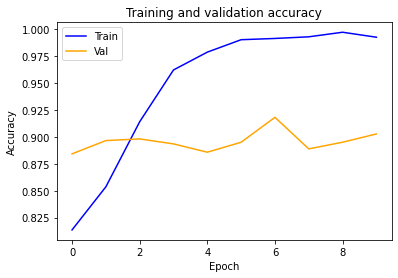

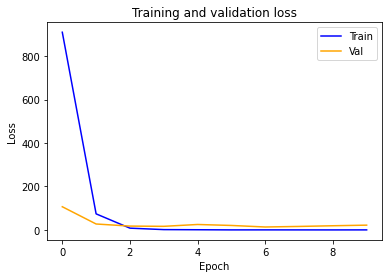

In [27]:
plot(history)

In [28]:
baseline_model.save(drive_root_dir+'level_4_baseline.h5')

### Transfer Learning with Inception V3

In [34]:
tl_base = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet',input_shape=(229,229,3))

fine_tune_model = Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(48, activation='relu'),
  layers.Dense(num_classes)
])

model_input = tl_base.input
model_output = fine_tune_model(tl_base.output)

tl_inception_model = tf.keras.Model(model_input,model_output)


In [35]:
tl_inception_model.compile(optimizer='adam',
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=['accuracy'])

In [36]:
epochs=10
history = tl_inception_model.fit(
  lvl4_train_data,
  validation_data=lvl4_val_data,
  epochs=epochs
)

Epoch 1/10
82/82 [==============================] - 21s 258ms/step - loss: 0.3677 - accuracy: 0.8752 - val_loss: 0.9036 - val_accuracy: 0.8688
Epoch 2/10
82/82 [==============================] - 20s 244ms/step - loss: 0.2739 - accuracy: 0.9091 - val_loss: 23.6934 - val_accuracy: 0.4352
Epoch 3/10
82/82 [==============================] - 20s 245ms/step - loss: 0.2793 - accuracy: 0.9006 - val_loss: 0.6643 - val_accuracy: 0.8580
Epoch 4/10
82/82 [==============================] - 20s 246ms/step - loss: 0.2458 - accuracy: 0.9176 - val_loss: 1.3734 - val_accuracy: 0.8611
Epoch 5/10
82/82 [==============================] - 20s 247ms/step - loss: 0.2492 - accuracy: 0.9018 - val_loss: 0.3364 - val_accuracy: 0.9028
Epoch 6/10
82/82 [==============================] - 20s 247ms/step - loss: 0.2395 - accuracy: 0.9010 - val_loss: 0.3640 - val_accuracy: 0.8765
Epoch 7/10
82/82 [==============================] - 20s 247ms/step - loss: 0.2558 - accuracy: 0.8933 - val_loss: 0.5867 - val_accuracy: 0.634

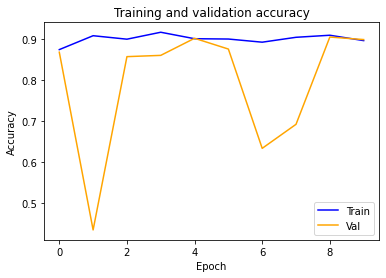

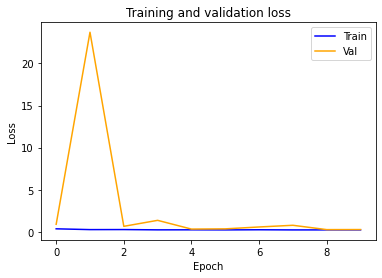

In [37]:
plot(history)

In [38]:
tl_inception_model.save(drive_root_dir+'level_4_tl_inception.h5')

## Level 3 Models

In [9]:
num_classes = 2
tl_base = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet',input_shape=(229,229,3))

fine_tune_model = Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(48, activation='relu'),
  layers.Dense(num_classes)
])

model_input = tl_base.input
model_output = fine_tune_model(tl_base.output)

tl_inception_model = tf.keras.Model(model_input,model_output)


In [10]:
tl_inception_model.compile(optimizer='adam',
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=['accuracy'])

In [11]:
epochs=10
history = tl_inception_model.fit(
  lvl3_train_data,
  validation_data=lvl3_val_data,
  epochs=epochs
)

Epoch 1/10
313/313 [==============================] - 80s 255ms/step - loss: 0.2784 - accuracy: 0.9214 - val_loss: 167.7752 - val_accuracy: 0.4078
Epoch 2/10
313/313 [==============================] - 76s 243ms/step - loss: 0.2131 - accuracy: 0.9343 - val_loss: 0.2635 - val_accuracy: 0.9432
Epoch 3/10
313/313 [==============================] - 77s 246ms/step - loss: 0.1646 - accuracy: 0.9458 - val_loss: 0.1698 - val_accuracy: 0.9220
Epoch 4/10
313/313 [==============================] - 78s 249ms/step - loss: 0.1542 - accuracy: 0.9514 - val_loss: 0.1836 - val_accuracy: 0.9304
Epoch 5/10
313/313 [==============================] - 78s 250ms/step - loss: 0.1442 - accuracy: 0.9549 - val_loss: 0.1660 - val_accuracy: 0.9484
Epoch 6/10
313/313 [==============================] - 78s 250ms/step - loss: 0.1354 - accuracy: 0.9568 - val_loss: 0.1577 - val_accuracy: 0.9416
Epoch 7/10
313/313 [==============================] - 78s 251ms/step - loss: 0.1240 - accuracy: 0.9629 - val_loss: 0.1570 - val_

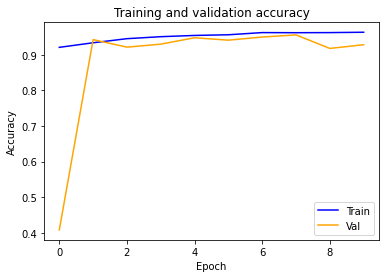

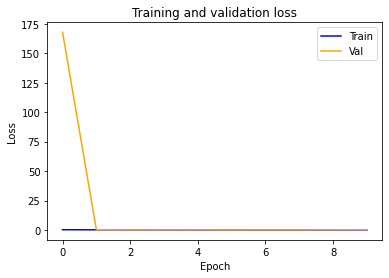

In [14]:
plot(history)

In [15]:
tl_inception_model.save(drive_root_dir+'level_3_tl_inception.h5')

# Heatmap on Test Images

In [9]:
test_data_slides = ['tumor_096', 'tumor_101', 'tumor_110']

In [10]:
from evaluation import heatmap_on_test

### Baseline model evaluation

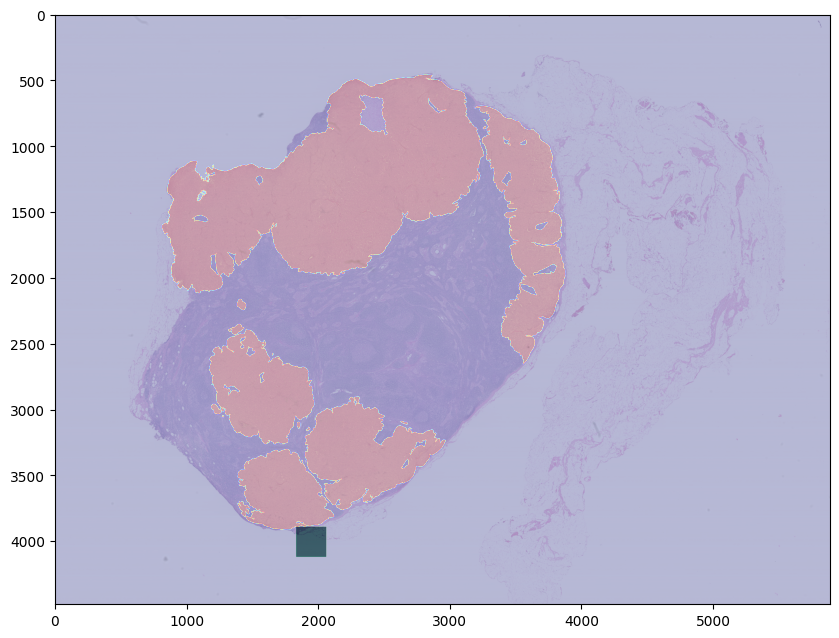

In [44]:
model_path = drive_root_dir+'level_4_baseline.h5'
level = 4
slice_size = 229
model = tf.keras.models.load_model(model_path)
cnf_matrix, precision, recall = heatmap_on_test(level,test_data_slides[2],slice_size,model,class_names).generate()

In [50]:
print(pd.DataFrame(cnf_matrix, columns=['Pred Negative','Pred Positive'], index=['Actual Negative','Actual Positive']))
print(f'\nprecision: {precision}')
print(f'recall: {recall}')

                 Pred Negative  Pred Positive
Actual Negative            348              0
Actual Positive            126              1

precision: 1.0
recall: 0.007874015748031496


### Transfer Learning with Inception V3 evaluation

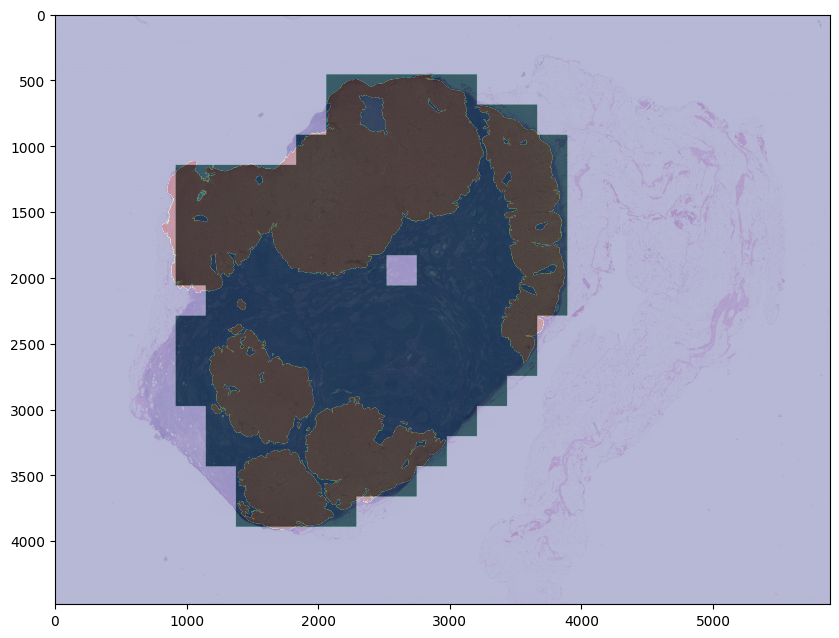

In [52]:
model_path = drive_root_dir+'level_4_tl_inception.h5'
level = 4
slice_size = 229
model = tf.keras.models.load_model(model_path)
cnf_matrix, precision, recall = heatmap_on_test(level,test_data_slides[2],slice_size,model,class_names).generate()

In [53]:
print(pd.DataFrame(cnf_matrix, columns=['Pred Negative','Pred Positive'], index=['Actual Negative','Actual Positive']))
print(f'\nprecision: {precision}')
print(f'recall: {recall}')

                 Pred Negative  Pred Positive
Actual Negative            313             35
Actual Positive             16            111

precision: 0.7602739726027398
recall: 0.8740157480314961


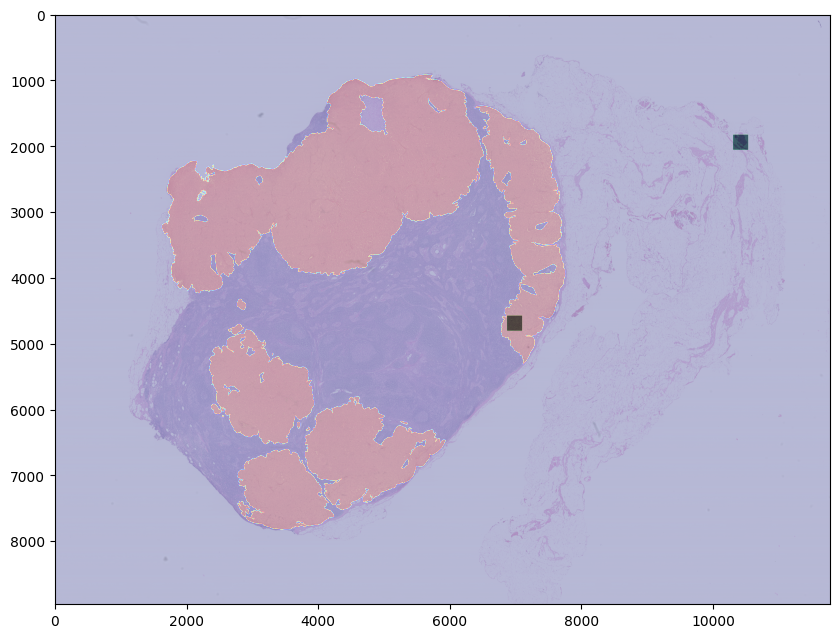

In [11]:
model_path = drive_root_dir+'level_3_tl_inception.h5'
level = 3
slice_size = 229
model = tf.keras.models.load_model(model_path)
cnf_matrix, precision, recall = heatmap_on_test(level,test_data_slides[2],slice_size,model,class_names).generate()

In [12]:
print(pd.DataFrame(cnf_matrix, columns=['Pred Negative','Pred Positive'], index=['Actual Negative','Actual Positive']))
print(f'\nprecision: {precision}')
print(f'recall: {recall}')

                 Pred Negative  Pred Positive
Actual Negative           1556              1
Actual Positive            431              1

precision: 0.5
recall: 0.0023148148148148147
